In [ ]:
#@title --- only COLAB
!pip install pyupbit > /dev/null
import matplotlib.pyplot as plt

In [ ]:
#@title --- Import / ID
import pyupbit
import pandas as pd

import time
import pyupbit
import datetime
import pytz
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests

#디스코드 URL
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1270240859123613697/bdk1cNecB_JbYbibGR54ra31BQPMgkvwm42ln76kBPNbrTIwulTPfyircTUJB03mXZqT"

# 로그인 정보
access = "l022huDYTe4lGoQAVtuTqc4pW8ZBoUx4JXFR11LU" # l022huDYTe4lGoQAVtuTqc4pW8ZBoUx4JXFR11LU
secret = "yRyxBhUxP2bfHCKom6ePZnF43FnGvOGuhCcx2Txy" # yRyxBhUxP2bfHCKom6ePZnF43FnGvOGuhCcx2Txy
################################################################################

In [ ]:
# @title --- 함수 : 디스코드
printed = True  # 출력 여부를 저장하는 변수
def print_once(msg):
    if printed == True:
        print(msg)
def send_starting_message_once(msg):
    if printed == True:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        message = {"content": f"{str(msg)} [{now.strftime('%Y-%m-%d %H:%M:%S')}]"}
        requests.post(DISCORD_WEBHOOK_URL, data=message)
        print(message)
def send_message_once(msg):
    if printed == True:
        message = {"content": f"{str(msg)}"}
        requests.post(DISCORD_WEBHOOK_URL, data=message)
        print(message)
def send_message_signal(msg):
    if printed == True:
        message = {"content": f"< 신호 : {str(msg)}>\n- \
        CCI : {int(df['CCI'][-1])} / \
        CCI_S : {int(df['CCI_signal'][-1])} / \
        K : {int(df['stoch_rsi_k'][-1])} / \
        D : {int(df['stoch_rsi_d'][-1])}\n- \
        under : {under:.1f} / \
        upper : {upper:.1f}"}
        requests.post(DISCORD_WEBHOOK_URL, data=message)
        print(message)
        # 다시 출력 안하게하려면 printed = False 추가할것
################################################################################

In [ ]:
#@title --- 함수 : df
coin_name = "KRW-BTC"
data_period = "minute5"
count=200
trade_period = [2,12,22,32,42,52,7,17,27,37,47,57]

# 코인정보 불러오기
def get_coin_price():
    df = pyupbit.get_ohlcv(coin_name, data_period, count)
    return df
# 시작 시간 조회
def get_start_time():
    df = pyupbit.get_ohlcv(coin_name, data_period, count=1)
    start_time = df.index[0]
    return start_time
# 잔고 조회
def get_balance(coin_name):
    balances = upbit.get_balances()
    for b in balances:
        if b['currency'] == coin_name:
            if b['balance'] is not None:
                return float(b['balance'])
            else:
                return 0
    return 0
# 현재가 조회
def get_current_price(coin_name):
    return pyupbit.get_orderbook(coin_name)["orderbook_units"][0]["ask_price"]
################################################################################

In [ ]:
#@title --- 함수 : RSI
RSI_period = 14
RSI_k_period = 5
RSI_d_period = 5
under_value = 40
upper_value = 60

def get_stoch_rsi_k_d(df, RSI_period, RSI_k_period, RSI_d_period):
  # Calculate %K
  df['stoch_rsi_k'] = 100 * (df['close'] - df['low'].rolling(RSI_period).min()) / (df['high'].rolling(RSI_period).max() - df['low'].rolling(RSI_period).min())
  # Calculate %D (Smoothed %K)
  df['stoch_rsi_d'] = df['stoch_rsi_k'].rolling(RSI_k_period).mean().rolling(RSI_d_period).mean()
  return df

def get_rsi_buy_signal(df):
  if df['stoch_rsi_k'][-1] <= under_value: #and df['stoch_rsi_d'][-1]
    under = 1
  else:
    under = 1 - (df['stoch_rsi_k'][-1] - under_value) / (100-under_value)
  return under
def get_rsi_sell_signal(df):
  if df['stoch_rsi_k'][-1] >= upper_value: #and df['stoch_rsi_d'][-1]
    upper = 1
  else:
    upper = 1 - (upper_value - df['stoch_rsi_k'][-1]) / upper_value
  return upper
################################################################################

In [ ]:
#@title --- 함수 : CCI
CCIperiod = 9
CCISperiod = 9
CCI_SELL_weight = 180

def get_cci_and_signal(df, CCIperiod, CCISperiod):
  df['TP'] = (df['high'] + df['low'] + df['close']) / 3
  df['SMA'] = df['TP'].rolling(CCIperiod).mean()
  df['MAD'] = df['TP'].rolling(CCIperiod).apply(lambda x: np.abs(x - x.mean()).mean()) # Calculate MAD using NumPy
  df['CCI'] = (df['TP'] - df['SMA']) / (0.015 * df['MAD'])
  df['CCI_signal'] = df['CCI'].ewm(span=CCISperiod).mean()
  return df
# Buy/Sell 신호 함수
def get_cci_buysell_signal(df):
    df['cci_buy_signal_1'] = (df['CCI'] > df['CCI'].shift(2)) & (df['CCI'] > df['CCI'].shift(1)) \
                           & (df['CCI_signal'] > df['CCI_signal'].shift(1) - 10) \
                           & (-100 < df['CCI'] < 100) \
                           & (df['volume'].shift(1) < df['volume'].shift(2) / 2) # '24.08.11 ~
    # df['cci_buy_signal_1'] = (df['CCI'] > df['CCI'].shift(2)) & (df['CCI'] > df['CCI'].shift(1)) & (df['CCI_signal'] > df['CCI_signal'].shift(1) - 10)  & (-100 < df['CCI'] < 100) # ~ '24.08.11
    # df['cci_buy_signal_1'] = (df['CCI']-100 < df['CCI_signal']) & (df['CCI'] > df['CCI'].shift(1)) & (df['CCI_signal'] < + 100 )
    # (df['CCI'] >= df['CCI_signal']) & (df['CCI'].shift(1) < df['CCI_signal'].shift(1)) & (df['CCI_signal'] <= 0 ) | ((df['CCI'] > df['CCI_signal']) &
    # 현재 CCI가 Signal보다 크고, 이전 CCI가 Signal보다 작을때 = CCI가 Signal을 상향돌파
    # 현재 CCI가 SIGNAL보다 크고, CCI(+10)가 증가할때
    df['cci_sell_signal_1'] = (df['CCI']+CCI_SELL_weight > df['CCI_signal']) \
                            & (df['CCI'] < df['CCI'].shift(1)) & (df['CCI_signal'] > - 100)
    # 한시간전 CCI가 SIGNAL보다 크고, 현재 CCI가 이전 CCI보다 작고, 현재 CCI(+200)이 SIGNAL보다 클때
    return df

# prompt: 매수신호=CCI지수가 CCI_signal 지수를 상향돌파할때 혹은 CCI지수가 CCI_signal 지수 위에서 하향하다가 상향으로 전환될 때.
# 매도신호=CCI지수가 CCI_signal 지수 위에서 상향하다가 하향으로 전환될 때.

# 매수신호 조건 :
# 1. 현재 CCI가 Signal보다 크고, 이전 CCI가 Signal보다 작을때 = CCI가 Signal을 상향돌파
# 2. 현재 CCI가 SIGNAL보다 크고, CCI(+10)가 증가할때
# 매도신호 조건
# 1. 한시간전 CCI가 SIGNAL보다 크고, 현재 CCI가 이전 CCI보다 작고, 현재 CCI(+200)이 SIGNAL보다 클때

# [C] 자동매매 본문

In [ ]:
# @title OLD 자동매매 코드
variable_name = ""
# prompt: while true 문 안에서 1시간에 한번만 실행하는 조건문
# 로그인
upbit = pyupbit.Upbit(access, secret)
print("autotrade start")
send_message_once("autotrade start")
# 자동매매 시작
while True: # 무한 루프를 시작합니다.
    try: # try 블록 안의 코드를 실행하고, 예외가 발생하면 except 블록으로 넘어갑니다.
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul')) # 현재 시간을 한국 시간대로 가져옵니다.
        start_time = get_start_time() # 시작 시간을 가져옵니다.
        end_time = start_time + datetime.timedelta(hours=1) # 종료 시간을 계산합니다.
################################################################################
        if now.minute == now.minute:#in data_period2:
            df = get_coin_price() # 코인 가격 데이터를 가져옵니다.
            df = get_cci_and_signal(df, CCIperiod, CCISperiod) # CCI와 Signal을 계산합니다.
            df = get_cci_buy_signal(df) # 매수 신호를 계산합니다.
            df = get_cci_sell_signal(df) # 매도 신호를 계산합니다.
            #df['buy_signal_C'] = 0
            #df['sell_signal_C'] = 0 # 신호를 초기화합니다.
################################################################################
            if df['cci_buy_signal_2'].iloc[-1] == 1: # 마지막 신호가 매수 신호이면 매수합니다.
                print('buy signal_B1 ok')
                krw = get_balance("KRW") # 원화 잔고를 가져옵니다.
                print('buy signal_B2 ok')
                if krw > 5000: # 원화 잔고가 5000원 이상이면 매수합니다.
                    upbit.buy_market_order(coin_name, krw*0.9995) # 시장가 매수 주문을 합니다.
            elif df['cci_sell_signal_2'].iloc[-1] == -1: # 마지막 신호가 매도 신호이면 매도합니다.
                print('buy signal_S1 ok')
                btc = get_balance("BTC") # 비트코인 잔고를 가져옵니다.
                print('buy signal_S2 ok')
                if btc > 0.00008: # 비트코인 잔고가 0.00008개 이상이면 매도합니다.
                    upbit.sell_market_order(coin_name, btc*0.9995) # 시장가 매도 주문을 합니다.
            else:
                print('pass')
                pass
            time.sleep(1) # 1초 동안 대기합니다.


    except Exception as e:
        print('erra', e)
        time.sleep(1)
    break

autotrade start
{'content': 'autotrade start'}
erra name 'get_cci_buy_signal' is not defined


In [ ]:
# @title 자동매매 시작 #########################################################
upbit = pyupbit.Upbit(access, secret)
send_message_once("\n{coin_auto_trade_setting}")

while True:
    try:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        # [A] trade_period 마다 자동매수 실행 ##################################
        if now.minute in trade_period:
            send_starting_message_once("\n[COIN_AUTO_TRADE_STARTING]")

        # 주가 데이터 정제
            # df = 0
            df = get_coin_price()
            df = get_cci_and_signal(df, CCIperiod, CCISperiod)
            df = get_cci_buysell_signal(df)
            send_message_once("\n[데이터 동기화 & 매수/매도 신호생성]")

#        # 초기 자본금 설정 / 거래 기록 저장
#            initial_balance = get_balance("KRW")
#            balance = initial_balance
#            btc_holding = 0
#            trades = []

            # [A-1] 마지막 신호가 매수 신호이면 매수 ###########################
            if df['cci_buy_signal_1'][-1] == True:
                krw = get_balance("KRW") # 원화 잔고
                if df['stock_rsi_k']<40 or df['stock_rsi_d']<40:
                    send_message_once(f"\n[CCI&RSI_매수신호/잔고:{krw}원]")
                    # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                    if krw > 5000:
                        upbit.buy_market_order(coin_name, krw*(1-fee))
                        send_message_once("\n<CCI&RSI_매수주문>")
                        printed = False  # 출력했으므로 False로 변경
                    else :
                        send_message_once("\n[KR_잔고부족]")
                        printed = False  # 출력했으므로 False로 변경
                else :
                    send_message_once(f"\n[CCI_매수신호/잔고:{krw}원]")
                    if krw*0.5 > 5000:
                        upbit.buy_market_order(coin_name, krw*(0.5-fee))
                        send_message_once("\n<CCI_매수주문>")
                        printed = False  # 출력했으므로 False로 변경
                    else :
                        send_message_once("\n[KR_잔고부족]")
                        printed = False  # 출력했으므로 False로 변경

#                    # [A-1-a-1] 매수 신호 발생 시 수익률 계산 ##################
#                    for i in range(1, len(df)):
#                        if df['cci_buy_signal_1'].iloc[i] and balance > 5000:
#                            buy_price = df['close'].iloc[i]
#                            buy_amount = (balance * 0.9995) / buy_price  # 수수료 0.05% 고려
#                            balance -= buy_amount * buy_price
#                            btc_holding += buy_amount
#                            trades.append(('buy', df.index[i], buy_price, buy_amount))

            # [A-2] 마지막 신호가 매도 신호이면 매도 ###########################
            elif df['cci_sell_signal_1'][-1] == True:
                btc = get_balance("BTC") # 비트코인 잔고
                if df['stock_rsi_k']>70 or df['stock_rsi_d']>70:
                    send_message_once(f"\n[CCI&RSI_매도신호/잔고:{btc}개]")
                    # [A-2-a] 비트코인 잔고가 0.00008개 이상이면 매도 ##########
                    if btc > 0.00008:
                        upbit.sell_market_order(coin_name, btc*(1-fee))
                        send_message_once("\n<CCI&RSI_매도주문>")
                        printed = False  # 출력했으므로 False로 변경
                    else :
                        send_message_once("\n[BTC_잔고부족]")
                        printed = False  # 출력했으므로 False로 변경
                else :
                    send_message_once(f"\n[CCI_매도신호/잔고:{btc}]개")
                    if btc > 0.00008:
                        upbit.sell_market_order(coin_name, btc*(0.5-fee))
                        send_message_once("\n<CCI_매도주문>")
                        printed = False
                    else :
                        send_message_once("\n[BTC_잔고부족]")
                        printed = False

#                    # [A-2-a-1] 매도 신호 발생 시 수익률 계산 ##################
#                    for i in range(1, len(df)):
#                        if df['cci_sell_signal_1'].iloc[i] and btc_holding > 0.00008:
#                            sell_price = df['close'].iloc[i]
#                            sell_amount = btc_holding * 0.9995  # 수수료 0.05% 고려
#                            balance += sell_amount * sell_price
#                            btc_holding -= sell_amount
#                            trades.append(('sell', df.index[i], sell_price, sell_amount))

            # ?
            time.sleep(10) # 1초 동안 대기합니다.

#            # 최종 잔고 계산 (마지막 시점에 보유 BTC 매도)
#            if btc_holding > 0:
#                final_price = df['close'].iloc[-1]
#                balance += btc_holding * final_price * 0.9995

#            # 수익률 계산
#            profit_ratio = (balance - initial_balance) / initial_balance * 100
#            send_message_once(f"\n초기 자본금: {initial_balance}원\n최종 잔고: {balance}원\n수익률: {profit_ratio:.2f}%\n거래 기록: {trades}")
#            printed = False

        # [B] 매매 시간이 아니면 원상복구 ######################################
        elif now.minute not in trade_period:
            printed = True  # 10분 경계를 벗어나면 다시 출력 가능하도록 False로 변경

    # Try 실패시 우회 ##########################################################
    except Exception as e:
        send_message_once(e)
        printed = True
        time.sleep(5)
    break

{'content': '\n{coin_auto_trade_setting}'}


In [ ]:
# @title '24.08.06 23:23 계정오류 고치고 ################################################################
import pyupbit
import pandas as pd

import time
import pyupbit
import datetime
import pytz
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests

# @title ID/PW/변수

#디스코드 웹훅 URL #############################################################
DISCORD_WEBHOOK_URL= "https://discord.com/api/webhooks/1270240859123613697/bdk1cNecB_JbYbibGR54ra31BQPMgkvwm42ln76kBPNbrTIwu>

# 로그인 정보 ##################################################################
access = "l022huDYTe4lGoQAVtuTqc4pW8ZBoUx4JXFR11LU"
secret = "yRyxBhUxP2bfHCKom6ePZnF43FnGvOGuhCcx2Txy"

# df 변수 ######################################################################
coin_name = "KRW-BTC"
data_period = "minute10"
count=200
trade_period = [1,11,21,31,41,51]

# CCI 변수 #####################################################################
CCIperiod = 9
CCISperiod = 9
CCI_SELL_weight = 200

# @title 공통함수

# 프린트/디스코드 메세지 전송 ##################################################
printed = True  # 출력 여부를 저장하는 변수
def print_once(msg):
    if printed == True:
        print(msg)
def send_starting_message_once(msg):
    if printed == True:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        message = {"content": f"[{now.strftime('%Y-%m-%d %H:%M:%S')}] {str(msg)}"}
        requests.post(DISCORD_WEBHOOK_URL, data=message)
        print(message)
def send_message_once(msg):
    if printed == True:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        message = {"content": f"{str(msg)}"}
        requests.post(DISCORD_WEBHOOK_URL, data=message)
        print(message)
        # 다시 출력 안하게하려면 printed = False 추가할것

# 코인정보 불러오기 ############################################################
def get_coin_price():
    df = pyupbit.get_ohlcv(coin_name, data_period, count)
    return df
# 시작 시간 조회 ###############################################################
def get_start_time():
    df = pyupbit.get_ohlcv(coin_name, data_period, count=1)
    start_time = df.index[0]
    return start_time
# 잔고 조회 ####################################################################
def get_balance(coin_name):
    balances = upbit.get_balances()
    for b in balances:
        if b['currency'] == coin_name:
            if b['balance'] is not None:
                return float(b['balance'])
            else:
                return 0
    return 0
# 현재가 조회 ##################################################################
def get_current_price(coin_name):
    return pyupbit.get_orderbook(coin_name)["orderbook_units"][0]["ask_price"]

# @title CCI/Signal 데이터 정제 함수 ###########################################
def get_cci_and_signal(df, CCIperiod, CCISperiod):
  df['TP'] = (df['high'] + df['low'] + df['close']) / 3
  df['SMA'] = df['TP'].rolling(CCIperiod).mean()
  df['MAD'] = df['TP'].rolling(CCIperiod).apply(lambda x: np.abs(x - x.mean()).mean())
  df['CCI'] = (df['TP'] - df['SMA']) / (0.015 * df['MAD'])
  df['CCI_signal'] = df['CCI'].ewm(span=CCISperiod).mean()
  return df

# @title CCI Buy/Sell 신호 계산 함수 ###########################################
def get_cci_buysell_signal(df):
    df['cci_buy_signal_1'] = (df['CCI'] > df['CCI'].shift(1)) & (df['CCI_signal'] > df['CCI_signal'].shift(1)) & (df['CCI'] < 100)
    df['cci_sell_signal_1'] = (df['CCI'] > df['CCI_signal']) & (df['CCI']+CCI_SELL_weight > df['CCI_signal']) & (df['CCI'] < df['CCI'].shift(1)) & (df['CCI_signal'] > -100)
    return df

# @title 자동매매 시작 #########################################################
upbit = pyupbit.Upbit(access, secret)
send_starting_message_once("\ncoin_auto_trade_setting")

while True:
    try:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        # [A] trade_period 마다 자동매수 실행 ##################################
        if now.minute in trade_period:
            send_starting_message_once("\n[COIN_AUTO_TRADE_STARTING]")

        # 주가 데이터 정제
            # df = 0
            df = get_coin_price()
            df = get_cci_and_signal(df, CCIperiod, CCISperiod)
            df = get_cci_buysell_signal(df)
            send_message_once("\n[데이터 동기화 & 매수/매도 신호생성]")

        # 초기 자본금 설정 / 거래 기록 저장
            initial_balance = get_balance("KRW")
            balance = initial_balance
            btc_holding = 0
            trades = []
            send_message_once("\n초기 자본금 설정")

            # [A-1] 마지막 신호가 매수 신호이면 매수 ###########################
            if df['cci_buy_signal_1'][-1] == True:
                krw = get_balance("KRW") # 원화 잔고
                send_message_once(f"\n[매수신호/잔고 : {krw}]")

                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #####################
                if krw > 5000:
                    upbit.buy_market_order(coin_name, krw*0.9995)
                    send_message_once("\n<매수주문>")
                    #printed = False  # 출력했으므로 False로 변경

                    # [A-1-a-1] 매수 신호 발생 시 수익률 계산 ##################
                    for i in range(1, len(df)):
                        if df['cci_buy_signal_1'].iloc[i] and balance > 5000:
                            buy_price = df['close'].iloc[i]
                            buy_amount = (balance * 0.9995) / buy_price  # 수수료 0.05% 고려
                            balance -= buy_amount * buy_price
                            btc_holding += buy_amount
                            trades.append(('buy', df.index[i], buy_price, buy_amount))

                # [A-1-b] 원화 잔고가 5000원 이하이면 잔고부족 #################
                else :
                    send_message_once("\n(KRW잔고부족)")
                    printed = False  # 출력했으므로 False로 변경

            # [A-2] 마지막 신호가 매도 신호이면 매도 ###########################
                        elif df['cci_sell_signal_1'][-1] == True:
                btc = get_balance("BTC") # 비트코인 잔고
                send_message_once(f"\n[매도신호/잔고 : {btc}]")

                # [A-2-a] 비트코인 잔고가 0.00008개 이상이면 매도 ##############
                if btc > 0.00008:
                    upbit.sell_market_order(coin_name, btc*0.9995)
                    send_message_once("\n<매도주문>")
                    #printed = False  # 출력했으므로 False로 변경

                    # [A-2-a-1] 매도 신호 발생 시 수익률 계산 ##################
                    for i in range(1, len(df)):
                        if df['cci_sell_signal_1'].iloc[i] and btc_holding > 0.00008:
                            sell_price = df['close'].iloc[i]
                            sell_amount = btc_holding * 0.9995  # 수수료 0.05% 고려
                            balance += sell_amount * sell_price
                            btc_holding -= sell_amount
                            trades.append(('sell', df.index[i], sell_price, sell_amount))

                # [A-2-b] 비트코인 잔고가 0.00008개 이하이면 잔고부족 ##########
                else :
                    send_message_once("\n(BTC잔고부족)")
                    #printed = False  # 출력했으므로 False로 변경

            # [A-3] 매수/매도 신호가 없으면 PASS ###############################
            else :
                send_message_once("\n<PASS>")
                #printed = False  # 출력했으므로 False로 변경
                pass

            # ?
            time.sleep(10) # 1초 동안 대기합니다.

            # 최종 잔고 계산 (마지막 시점에 보유 BTC 매도)
            if btc_holding > 0:
                final_price = df['close'].iloc[-1]
                balance += btc_holding * final_price * 0.9995

            # 수익률 계산
                        profit_ratio = (balance - initial_balance) / initial_balance * 100
            send_message_once(f"\n초기 자본금: {initial_balance}원\n최종 잔고: {balance}원\n수익률: {profit_ratio:.2f}%\n거래 기록: {trades}")
            printed = False

        # [B] 매매 시간이 아니면 원상복구 ######################################
        elif now.minute not in trade_period:
            printed = True  # 10분 경계를 벗어나면 다시 출력 가능하도록 False로 변경

    # Try 실패시 우회 ##########################################################
    except Exception as e:
        send_message_once(e)
        printed = True
        time.sleep(5)

In [ ]:
# @title 자동매매 시작 #########################################################
upbit = pyupbit.Upbit(access, secret)
send_starting_message_once("{Trade_Setting}")

while True:
    try:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        # [A] trade_period 마다 자동매수 실행 ##################################
        if now.minute in trade_period:
            send_starting_message_once("{Auto_Trading}")

        # 주가 데이터 정제
            # df = 0
            df = get_coin_price()
            df = get_cci_and_signal(df, CCIperiod, CCISperiod)
            df = get_cci_buysell_signal(df)
            df = get_stoch_rsi_k_d(df,RSI_period,RSI_k_period,RSI_d_period)
            under = get_rsi_buy_signal(df)
            upper = get_rsi_sell_signal(df)
            send_message_once("[데이터 동기화]")

            if 'price2' in locals():
                price1 = price2
                price2 = get_current_price(coin_name)
                if price1 < price2:
                    send_message_once(f"< 상승장 >")
                else:
                    send_message_once(f"< 하락장 >")
                send_message_once(f"- 이전시세 : {price1:,}\n- 현재시세 : {price2:,}\n------------------------------")
            else:
                price2 = get_current_price(coin_name)
                send_message_once(f"- 현재시세 : {price2:,}\n------------------------------")
            #send_message_once("")
            if "krw2" and "btc2" in locals() :
                krw1 = krw2
                btc1 = btc2
            else :
                pass
            krw2 = get_balance("KRW") # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
            #send_message_once("")
            send_message_once("[매수/매도 신호생성]")
            # [A-1] 마지막 신호가 매수 신호이면 매수 ###########################
            if df['cci_buy_signal_1'][-1] == True:
                send_message_once(f"< 신호 : 매수 >\n- CCI : {int(df['CCI'][-1])}\n- RSI : {int(df['stoch_rsi_k'][-1])} / under : {under:.1f}")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if krw2*under > 5000:
                    upbit.buy_market_order(coin_name, krw2*(under-fee))
                    send_message_once("=====> 매수주문")
                else :
                    send_message_once("=====> KR_잔고부족")



                if df['stoch_rsi_k'][-1]<40 or df['stoch_rsi_d'][-1]<40:
                    send_message_once(f"< 신호 : 매수 >\n- CCI : {int(df['CCI'][-1])}\n- RSI : {int(df['stoch_rsi_k'][-1])}")
                    # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                    if krw2 > 5000:
                        upbit.buy_market_order(coin_name, krw2*(1-fee))
                        send_message_once("=====> CCI & RSI_매수주문")
                    else :
                        send_message_once("=====> KR_잔고부족")
                else :
                    send_message_once(f"< 신호 : 매수 >\n- CCI : {int(df['CCI'][-1])}\n- RSI : {int(df['stoch_rsi_k'][-1])}")
                    if krw2*0.3 > 5000:
                        upbit.buy_market_order(coin_name, krw2*(0.3-fee))
                        send_message_once("=====> CCI_매수주문")
                    else :
                        send_message_once("=====> KR_잔고부족")

            # [A-2] 마지막 신호가 매도 신호이면 매도 ###########################
            elif df['cci_sell_signal_1'][-1] == True:
                btc = get_balance("BTC") # 비트코인 잔고
                if df['stoch_rsi_k'][-1]>60 or df['stoch_rsi_d'][-1]>60:
                    send_message_once(f"< 신호 : 매도 >\n- CCI : {int(df['CCI'][-1])}\n- RSI : {int(df['stoch_rsi_k'][-1])}")
                    # [A-2-a] 비트코인 잔고가 0.00008개 이상이면 매도 ##########
                    if btc2 > 0.00008:
                        upbit.sell_market_order(coin_name, btc2*(1-fee))
                        send_message_once("=====> CCI & RSI_매도주문")
                    else :
                        send_message_once("=====> BTC_잔고부족")
                else :
                    send_message_once(f"< 신호 : 매도 >\n- CCI : {int(df['CCI'][-1])}\n- RSI : {int(df['stoch_rsi_k'][-1])}")
                    if btc2*0.3 > 0.00008:
                        upbit.sell_market_order(coin_name, btc2*(0.3-fee))
                        send_message_once("=====> CCI_매도주문")
                    else :
                        send_message_once("=====> BTC_잔고부족")

            else :
                send_message_once("< PASS >")
                pass
            # ?
            #send_message_once("\n")
            price2 = get_current_price(coin_name)
            krw2 = get_balance("KRW") # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            total2 = krw2 + btc2*price2
            send_message_once(f"------------------------------\n- 기말현금 : {int(krw2):,}원\n- 기말코인 : {btc2:.5f}개\n=========================\n= 총자산 : {int(total2):,}원")
            #send_message_once("\n

            printed = False
            time.sleep(60) # 1초 동안 대기합니다.


        # [B] 매매 시간이 아니면 원상복구 ######################################
        elif now.minute not in trade_period:
            printed = True  # 10분 경계를 벗어나면 다시 출력 가능하도록 False로 변경

    # Try 실패시 우회 ##########################################################
    except Exception as e:
        send_message_once(e)
        printed = True
        time.sleep(5)
    break

In [ ]:
# @title 자동매매_RSI 비례 매수/매도 #########################################################
upbit = pyupbit.Upbit(access, secret)
send_starting_message_once("{Trade_Setting}")

while True:
    try:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        # [A] trade_period 마다 자동매수 실행 ##################################
        if now.minute in trade_period:
            send_starting_message_once("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n{Auto_Trading}")

        # 주가 데이터 정제
            # df = 0
            df = get_coin_price()
            df = get_cci_and_signal(df, CCIperiod, CCISperiod)
            df = get_cci_buysell_signal(df)
            df = get_stoch_rsi_k_d(df,RSI_period,RSI_k_period,RSI_d_period)
            under = get_rsi_buy_signal(df)
            upper = get_rsi_sell_signal(df)
            send_message_once("[데이터 동기화]")

            if 'price2' in locals():
                price1 = price2
                price2 = get_current_price(coin_name)
                if price1 < price2:
                    send_message_once(f"< 상승장 >")
                else:
                    send_message_once(f"< 하락장 >")
                send_message_once(f"- 이전시세 : {price1:,}\n- 현재시세 : {price2:,}\n------------------------------")
            else:
                price2 = get_current_price(coin_name)
                send_message_once(f"- 현재시세 : {price2:,}\n------------------------------")
            #send_message_once("")
            if "krw2" and "btc2" in locals() :
                krw1 = krw2
                btc1 = btc2
            else :
                pass
            krw2 = get_balance("KRW") / 10 # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
            #send_message_once("")
            send_message_once("[매수/매도 신호생성]")
            # [A-1] 마지막 신호가 매수 신호이면 매수 ###########################

            if df['cci_buy_signal_1'][-1] == True and df['cci_sell_signal_1'] == True :
                send_message_once(f"< 신호 : 조정 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if under > upper and krw2*(under-upper) > 5000 :
                    upbit.buy_market_order(coin_name, krw2*(under-upper-fee))
                    send_message_once("=========================> 매수조정주문")
                elif under < upper and btc2*(upper-under) > 0.00008 :
                    upbit.sell_market_order(coin_name, btc2*(upper-under-fee))
                    send_message_once("=========================> 매도조정주문")
                else :
                    send_message_once("=========================> 조정잔고부족")

            elif df['cci_buy_signal_1'][-1] == True:
                send_message_once(f"< 신호 : 매수 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if krw2*under > 5000:
                    upbit.buy_market_order(coin_name, krw2*(under-fee))
                    send_message_once("=========================> 매수주문")
                else :
                    send_message_once("=========================> KR_잔고부족")
            # [A-2] 마지막 신호가 매도 신호이면 매도 ###########################
            elif df['cci_sell_signal_1'][-1] == True:
                send_message_once(f"< 신호 : 매도 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                # [A-2-a] 비트코인 잔고가 0.00008개 이상이면 매도 ##########
                if btc2*upper > 0.00008:
                    upbit.sell_market_order(coin_name, btc2*(upper-fee))
                    send_message_once("=========================> 매도주문")
                else :
                    send_message_once("=========================> BTC_잔고부족")

            else :
                send_message_once(f"< 신호 : 없음 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                send_message_once("=========================> PASS")
                pass
            # ?
            #send_message_once("\n")
            price2 = get_current_price(coin_name)
            krw2 = get_balance("KRW") # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            if 'total2' in locals():
                total1 = total2
                total2 = krw2 + btc2*price2
                send_message_once(f"------------------------------\n- 기말현금 : {int(krw2):,}원\n- 기말코인 : {btc2:.5f}개\n=========================\n= 총자산 : {int(total2):,}원({int(total2-total1):,}원)")
            else:
                total2 = krw2 + btc2*price2
                send_message_once(f"------------------------------\n- 기말현금 : {int(krw2):,}원\n- 기말코인 : {btc2:.5f}개\n=========================\n= 총자산 : {int(total2):,}원")
            send_message_once("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            #send_message_once("\n
            printed = False
            time.sleep(60) # 1초 동안 대기합니다.


        # [B] 매매 시간이 아니면 원상복구 ######################################
        elif now.minute not in trade_period:
            printed = True  # 10분 경계를 벗어나면 다시 출력 가능하도록 False로 변경

    # Try 실패시 우회 ##########################################################
    except Exception as e:
        send_message_once(e)
        printed = True
        time.sleep(5)
    break

In [ ]:
#@title 자동매매 : CCI + RSI + RSI 비례
upbit = pyupbit.Upbit(access, secret)
send_starting_message_once("{Trade_Setting}")
price1 = 0
krw1, btc1 = 0
total1 = 0
fee = 0.0005

while True:
    try:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        # [A] trade_period 마다 자동매수 실행 ##################################
        if now.minute in trade_period:
            send_starting_message_once("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n{Auto_Trading}")

        # 주가 데이터 정제
            df = get_coin_price()
            df = get_stoch_rsi_k_d(df,RSI_period,RSI_k_period,RSI_d_period)
            under = get_rsi_buy_signal(df)
            upper = get_rsi_sell_signal(df)
            df = get_cci_and_signal(df, CCIperiod, CCISperiod)
            df = get_cci_buysell_signal(df)
            send_message_once("[데이터 동기화]")

            price2 = get_current_price(coin_name)
            if  price1 < price2:
                send_message_once(f"< 상승장 >")
            else:
                send_message_once(f"< 하락장 >")
            send_message_once(f"- 이전시세 : {price1:,}\n- 현재시세 : {price2:,}\n------------------------------")
            price1 = price2

            krw2 = get_balance("KRW") / 10 # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
            send_message_once("[매수/매도 신호생성]")
            krw1, btc1 = krw2, btc2

            if df['cci_buy_signal_1'][-1] == True and df['cci_sell_signal_1'] == True :
                send_message_signal("조정")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if under > upper and krw2*(under-upper) > 5000 :
                    upbit.buy_market_order(coin_name, krw2*(under-upper-fee))
                    send_message_once("=========================> 매수조정주문")
                elif under < upper and btc2*(upper-under) > 0.00008 :
                    upbit.sell_market_order(coin_name, btc2*(upper-under-fee))
                    send_message_once("=========================> 매도조정주문")
                else :
                    send_message_once("=========================> 조정잔고부족")

            elif df['cci_buy_signal_1'][-1] == True:
                send_message_signal("매수")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if krw2*under > 5000:
                    upbit.buy_market_order(coin_name, krw2*(under-fee))
                    send_message_once("=========================> 매수주문")
                else :
                    send_message_once("=========================> KR_잔고부족")
            # [A-2] 마지막 신호가 매도 신호이면 매도 ###########################
            elif df['cci_sell_signal_1'][-1] == True:
                send_message_signal("매도")
                # [A-2-a] 비트코인 잔고가 0.00008개 이상이면 매도 ##########
                if btc2*upper > 0.00008:
                    upbit.sell_market_order(coin_name, btc2*(upper-fee))
                    send_message_once("=========================> 매도주문")
                else :
                    send_message_once("=========================> BTC_잔고부족")

            else :
                send_message_signal("없음")
                send_message_once("=========================> PASS")
                pass
            # ?
            #send_message_once("\n")
            krw2 = get_balance("KRW") # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            total2 = krw2 + btc2*price2
            send_message_once(f"------------------------------\n- 기말현금 : {int(krw2):,}원\n- 기말코인 : {btc2:.5f}개\n=========================\n= 총자산 : {int(total2):,}원({int(total2-total1):,}원)")
            total1 = total2
            send_message_once("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            #send_message_once("\n
            printed = False
            time.sleep(60) # 1초 동안 대기합니다.

        # [B] 매매 시간이 아니면 원상복구 ######################################
        elif now.minute not in trade_period:
            printed = True  # 10분 경계를 벗어나면 다시 출력 가능하도록 False로 변경

    # Try 실패시 우회 ##########################################################
    except Exception as e:
        send_message_once(e)
        printed = True
        time.sleep(5)
    break

In [ ]:
# @title 자동매매_안쉬고 계속 #########################################################
upbit = pyupbit.Upbit(access, secret)
send_starting_message_once("{Trade_Setting}")

while True:
    try:
        now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
        # [A] trade_period 마다 자동매수 실행 ##################################
        if True :
            #send_starting_message_once("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n{Auto_Trading}")

        # 주가 데이터 정제
            # df = 0
            df = get_coin_price()
            df = get_cci_and_signal(df, CCIperiod, CCISperiod)
            df = get_cci_buysell_signal(df)
            df = get_stoch_rsi_k_d(df,RSI_period,RSI_k_period,RSI_d_period)
            under = get_rsi_buy_signal(df)
            upper = get_rsi_sell_signal(df)
            #send_message_once("[데이터 동기화]")

            #if 'price2' in locals():
            #    price1 = price2
            #    price2 = get_current_price(coin_name)
            #    if price1 < price2:
            #        send_message_once(f"< 상승장 >")
            #    else:
            #        send_message_once(f"< 하락장 >")
            #    send_message_once(f"- 이전시세 : {price1:,}\n- 현재시세 : {price2:,}\n------------------------------")
            #else:
            #    price2 = get_current_price(coin_name)
            #    send_message_once(f"- 현재시세 : {price2:,}\n------------------------------")
            #send_message_once("")
            #if "krw2" and "btc2" in locals() :
            #    krw1 = krw2
            #    btc1 = btc2
            #else :
            #    pass
            krw2 = get_balance("KRW") / 10 # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            #send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
            #send_message_once("")
            #send_message_once("[매수/매도 신호생성]")
            # [A-1] 마지막 신호가 매수 신호이면 매수 ###########################

            if df['cci_buy_signal_1'][-1] == True and df['cci_sell_signal_1'] == True :
                send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
                send_message_once(f"< 신호 : 조정 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if under > upper and krw2*(under-upper) > 5000 :
                    upbit.buy_market_order(coin_name, krw2*(under-upper-fee))
                    send_message_once("=========================> 매수조정주문")
                elif under < upper and btc2*(upper-under) > 0.00008 :
                    upbit.sell_market_order(coin_name, btc2*(upper-under-fee))
                    send_message_once("=========================> 매도조정주문")
                else :
                    send_message_once("=========================> 조정잔고부족")

            elif df['cci_buy_signal_1'][-1] == True:
                send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
                send_message_once(f"< 신호 : 매수 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                # [A-1-a] 원화 잔고가 5000원 이상이면 매수 #################
                if krw2*under > 5000:
                    upbit.buy_market_order(coin_name, krw2*(under-fee))
                    send_message_once("=========================> 매수주문")
                else :
                    send_message_once("=========================> KR_잔고부족")
            # [A-2] 마지막 신호가 매도 신호이면 매도 ###########################
            elif df['cci_sell_signal_1'][-1] == True:
                send_message_once(f"- 기초현금 : {int(krw2):,}원\n- 기초코인 : {btc2:.5f}개\n=========================")
                send_message_once(f"< 신호 : 매도 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                # [A-2-a] 비트코인 잔고가 0.00008개 이상이면 매도 ##########
                if btc2*upper > 0.00008:
                    upbit.sell_market_order(coin_name, btc2*(upper-fee))
                    send_message_once("=========================> 매도주문")
                else :
                    send_message_once("=========================> BTC_잔고부족")

            else :
                #send_message_once(f"< 신호 : 없음 >\n- CCI : {int(df['CCI'][-1])} / CCI_S : {int(df['CCI_signal'][-1])} / K : {int(df['stoch_rsi_k'][-1])} / D : {int(df['stoch_rsi_d'][-1])}\n- under : {under:.1f} / upper : {upper:.1f}")
                #send_message_once("=========================> PASS")
                pass
            # ?
            #send_message_once("\n")
            price2 = get_current_price(coin_name)
            krw2 = get_balance("KRW") # 원화 잔고
            btc2 = get_balance("BTC") # 비트코인 잔고
            if 'total2' in locals():
                total1 = total2
                total2 = krw2 + btc2*price2
                send_message_once(f"------------------------------\n- 기말현금 : {int(krw2):,}원\n- 기말코인 : {btc2:.5f}개\n=========================\n= 총자산 : {int(total2):,}원({int(total2-total1):,}원)")
            else:
                total2 = krw2 + btc2*price2
                send_message_once(f"------------------------------\n- 기말현금 : {int(krw2):,}원\n- 기말코인 : {btc2:.5f}개\n=========================\n= 총자산 : {int(total2):,}원")
            send_message_once("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            #send_message_once("\n
            printed = False
            time.sleep(1) # 1초 동안 대기합니다.


        # [B] 매매 시간이 아니면 원상복구 ######################################
    #    elif now.minute not in trade_period:
    #        printed = True  # 10분 경계를 벗어나면 다시 출력 가능하도록 False로 변경

    # Try 실패시 우회 ##########################################################
    except Exception as e:
        send_message_once(e)
        printed = True
        time.sleep(5)
    break

# [D] 백테스터 확인


In [ ]:
# @title 백테스트 확인용 데이터 정제
df = get_coin_price()
df = get_cci_and_signal(df, CCIperiod, CCISperiod)
df = get_cci_buysell_signal(df)
# prompt: df의 close열의 최대값을 400, 최소값을 200으로 낮춰서 LOG라는 열에 넣어줘
df['LOG'] = (df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min()) * (400 - 200) + 200

In [ ]:
df = get_stoch_rsi_k_d(df,14,5,5)

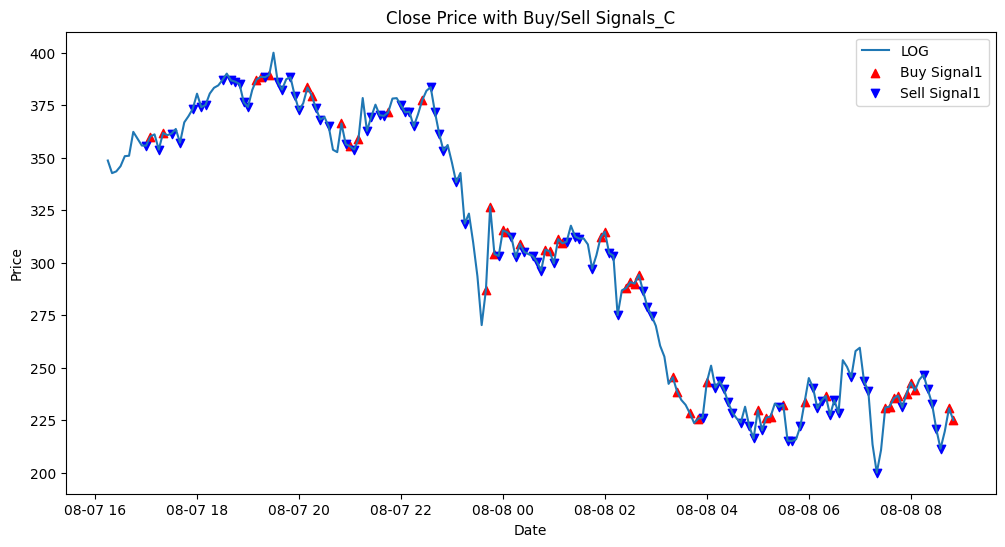

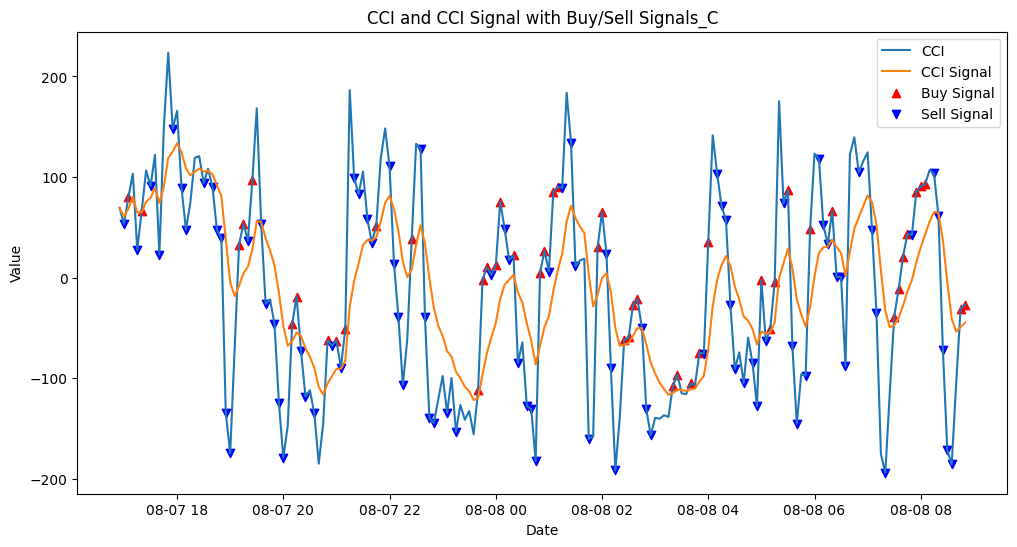

In [ ]:
# @title 가격 그래프 매수/매도 신호 표시
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['LOG'], label='LOG')
plt.scatter(df[df['cci_buy_signal_1']].index, df[df['cci_buy_signal_1']]['LOG'], marker='^', color='red', label='Buy Signal1')
plt.scatter(df[df['cci_sell_signal_1']].index, df[df['cci_sell_signal_1']]['LOG'], marker='v', color='blue', label='Sell Signal1')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price with Buy/Sell Signals_C')
plt.legend()
plt.show()

# 매수/매도 시점 표시
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CCI'], label='CCI')
plt.plot(df.index, df['CCI_signal'], label='CCI Signal')
plt.scatter(df[df['cci_buy_signal_1']].index, df[df['cci_buy_signal_1']]['CCI'], marker='^', color='red', label='Buy Signal')
plt.scatter(df[df['cci_sell_signal_1']].index, df[df['cci_sell_signal_1']]['CCI'], marker='v', color='blue', label='Sell Signal')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('CCI and CCI Signal with Buy/Sell Signals_C')
plt.legend()
plt.show()

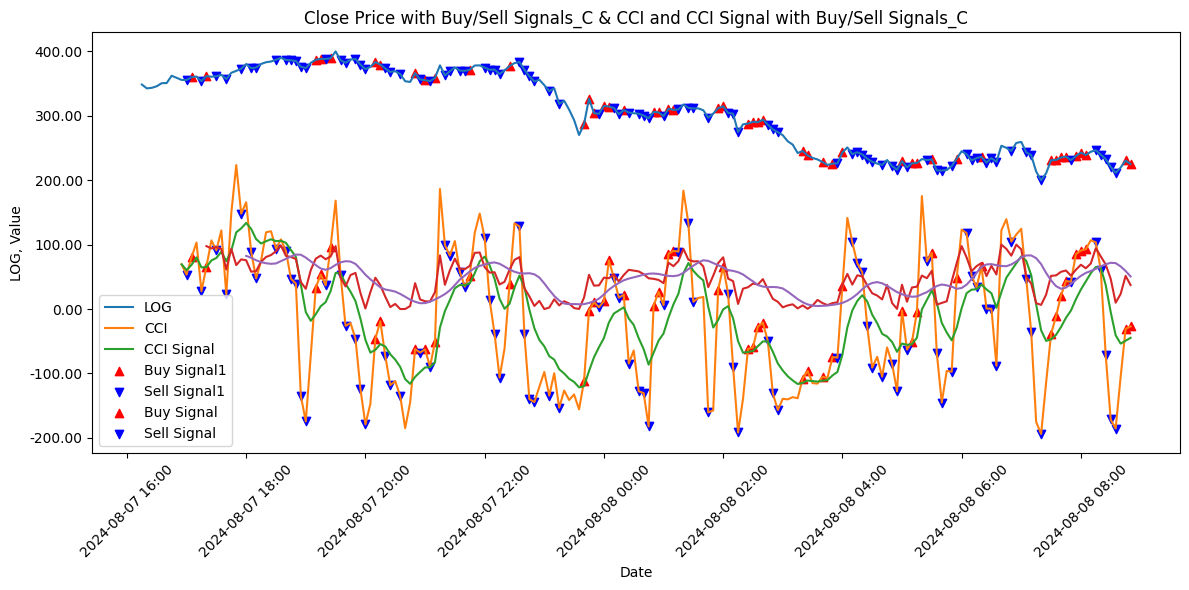

In [ ]:
# @title 그래프 하나로 그리기
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates # Import the mdates module

# ... (rest of your code)

# 매수/매도 신호 표시
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['LOG'], label='LOG')
ax.plot(df.index, df['CCI'], label='CCI')
ax.plot(df.index, df['CCI_signal'], label='CCI Signal')
ax.plot(df.index, df['stoch_rsi_k'])
ax.plot(df.index, df['stoch_rsi_d'])

ax.scatter(df[df['cci_buy_signal_1']].index, df[df['cci_buy_signal_1']]['LOG'], marker='^', color='red', label='Buy Signal1')
ax.scatter(df[df['cci_sell_signal_1']].index, df[df['cci_sell_signal_1']]['LOG'], marker='v', color='blue', label='Sell Signal1')
plt.scatter(df[df['cci_buy_signal_1']].index, df[df['cci_buy_signal_1']]['CCI'], marker='^', color='red', label='Buy Signal')
plt.scatter(df[df['cci_sell_signal_1']].index, df[df['cci_sell_signal_1']]['CCI'], marker='v', color='blue', label='Sell Signal')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # 날짜 형식 지정
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))  # y축 숫자 형식 지정 (소수점 두 자리까지)
plt.xlabel('Date')
plt.ylabel('LOG, Value')
plt.title('Close Price with Buy/Sell Signals_C & CCI and CCI Signal with Buy/Sell Signals_C')
plt.legend()
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()

In [ ]:
# @title 백테스트 수익률 다른방법
# prompt: 위 코드의 수익률

# 백테스팅 함수
def backtest(df):
    # 초기 자본금 설정
    initial_balance = 1000000
    balance = initial_balance
    # 보유 코인 수 초기화
    coin_holding = 0

    # 거래 내역 저장 리스트
    trades = []

    for i in range(len(df)):
        if df['cci_buy_signal_1'][i] == True and balance > 0:
            # 매수 신호 발생 시
            price = df['close'][i]
            coin_holding = balance / price * 0.9995  # 수수료 0.05% 고려
            balance = 0
            trades.append(('buy', df.index[i], price, coin_holding))
        elif df['cci_sell_signal_1'][i] == True and coin_holding > 0:
            # 매도 신호 발생 시
            price = df['close'][i]
            balance = coin_holding * price * 0.9995  # 수수료 0.05% 고려
            coin_holding = 0
            trades.append(('sell', df.index[i], price, balance))

    # 마지막 시점에 보유 코인 매도
    if coin_holding > 0:
        price = df['close'][-1]
        balance = coin_holding * price * 0.9995
        trades.append(('sell', df.index[-1], price, balance))

    # 수익률 계산
    profit = (balance - initial_balance) / initial_balance * 100

    return profit, trades

# 백테스팅 실행 및 결과 출력
profit, trades = backtest(df)
print("수익률: {:.2f}%".format(profit))

수익률: -4.29%


In [ ]:
# @title 백테스트 수익률 계산
# prompt: 위의 표대로 매수 및 매도 했을때의 수익률

# ... (Your existing code)

# 백테스팅 수익률 계산
# 초기 자본금 설정
initial_balance = 1000000
balance = initial_balance
btc_holding = 0

# 거래 기록 저장
trades = []

for i in range(1, len(df)):
    if df['cci_buy_signal_1'].iloc[i] and balance > 5000:
        # 매수 신호 발생 시
        buy_price = df['close'].iloc[i]
        buy_amount = (balance * 0.9995) / buy_price  # 수수료 0.05% 고려
        balance -= buy_amount * buy_price
        btc_holding += buy_amount
        trades.append(('buy', df.index[i], buy_price, buy_amount))
    elif df['cci_sell_signal_1'].iloc[i] and btc_holding > 0.00008:
        # 매도 신호 발생 시
        sell_price = df['close'].iloc[i]
        sell_amount = btc_holding * 0.9995  # 수수료 0.05% 고려
        balance += sell_amount * sell_price
        btc_holding -= sell_amount
        trades.append(('sell', df.index[i], sell_price, sell_amount))

# 최종 잔고 계산 (마지막 시점에 보유 BTC 매도)
if btc_holding > 0:
    final_price = df['close'].iloc[-1]
    balance += btc_holding * final_price * 0.9995

# 수익률 계산
profit_ratio = (balance - initial_balance) / initial_balance * 100

print(f"초기 자본금: {initial_balance}원")
print(f"최종 잔고: {balance}원")
print(f"수익률: {profit_ratio:.2f}%")

print("거래 기록:")
for trade in trades:
    print(trade)

초기 자본금: 1000000원
최종 잔고: 982769.8913781093원
수익률: -1.72%
거래 기록:
('buy', Timestamp('2024-08-07 17:05:00'), 81126000.0, 0.012320341197643173)
('sell', Timestamp('2024-08-07 17:15:00'), 81000000.0, 0.012314181027044352)
('buy', Timestamp('2024-08-07 17:20:00'), 81161000.0, 0.012289765883355272)
('sell', Timestamp('2024-08-07 17:30:00'), 81155000.0, 0.012289778090927118)
('buy', Timestamp('2024-08-07 19:10:00'), 81677000.0, 0.012211234219463683)
('sell', Timestamp('2024-08-07 19:20:00'), 81700000.0, 0.012211273491399414)
('buy', Timestamp('2024-08-07 19:25:00'), 81723000.0, 0.0122078350306998)
('sell', Timestamp('2024-08-07 19:35:00'), 81657000.0, 0.01220783674993015)
('buy', Timestamp('2024-08-07 20:10:00'), 81601000.0, 0.01221621951051346)
('sell', Timestamp('2024-08-07 20:20:00'), 81400000.0, 0.012216215319133169)
('buy', Timestamp('2024-08-07 20:50:00'), 81253000.0, 0.012238331567795526)
('sell', Timestamp('2024-08-07 20:55:00'), 81054000.0, 0.012238320509671195)
('buy', Timestamp('2024-

In [ ]:
# @title RSI/Signal 데이터 정제 함수 ###########################################
def calculate_stochastic_rsi(df, RSI_period, RSI_k_period, RSI_d_period):
    delta = df['close'].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    AVG_Gain = up.rolling(window=RSI_period).mean()
    AVG_Loss = abs(down.rolling(window=RSI_period).mean())
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    stoch_rsi_k = ((RSI - RSI.rolling(RSI_k_period).min()) / (RSI.rolling(RSI_k_period).max() - RSI.rolling(RSI_k_period).min())) * 100
    stoch_rsi_d = stoch_rsi_k.rolling(RSI_d_period).mean()
    return stoch_rsi_k, stoch_rsi_d

In [ ]:
# @title RSI/Signal 데이터 정제 함수 ###########################################
def calculate_stochastic_rsi(df, RSI_period, RSI_k_period, RSI_d_period):
    df['delta'] = df['close'].diff(1)
    df['delta'] = df['delta'].dropna()
    df['up'] = df['delta'].copy()
    df['down'] = df['delta'].copy()
    df['up'][df['up'] < 0] = 0
    df['down'][df['down'] > 0] = 0
    df['AVG_Gain'] = df['up'].rolling(window=RSI_period).mean()
    df['AVG_Loss'] = abs(df['down'].rolling(window=RSI_period).mean())
    df['RS'] = df['AVG_Gain'] / df['AVG_Loss']
    df['RSI'] = 100.0 - (100.0 / (1.0 + df['RS']))
    df['stoch_rsi_k'] = ((df['RSI'] - df['RSI'].rolling(RSI_k_period).min()) / (df['RSI'].rolling(RSI_k_period).max() - df['RSI'].rolling(RSI_k_period).min())) * 100
    df['stoch_rsi_d'] = df['stoch_rsi_k'].rolling(RSI_d_period).mean()
    return df

In [ ]:
# @title RSI Buy/Sell 신호 계산 함수 ###########################################
def get_best_parameters(df):
    best_RSI_period = None
    best_RSI_k_period = None
    best_RSI_d_period = None
    best_RSI_return = float('-inf')

    for RSI_period in range(5, 21):
        for RSI_k_period in range(3, 11):
            for RSI_d_period in range(2, 6):
                stoch_rsi_k, stoch_rsi_d = calculate_stochastic_rsi(df, RSI_period, RSI_k_period, RSI_d_period)
                df['RSI_signal'] = 0
                k_higher = stoch_rsi_k[stoch_rsi_k.index.isin(df.index)] > stoch_rsi_d[stoch_rsi_d.index.isin(df.index)]
                df.loc[k_higher[k_higher].index, 'RSI_signal'] = 'BUY_B'
                k_lower = stoch_rsi_k[stoch_rsi_k.index.isin(df.index)] < stoch_rsi_d[stoch_rsi_d.index.isin(df.index)]
                df.loc[k_lower[k_lower].index, 'RSI_signal'] = 'SELL_B'
                df['RSI_return'] = 0.0
                buy_price = 0.0
                sell_price = 0.0
                for i in range(1, len(df)):
                    if df['RSI_signal'][i] == 'BUY_B' and buy_price == 0.0:
                        buy_price = df['close'][i]
                    elif df['RSI_signal'][i] == 'SELL_B' and buy_price != 0.0:
                        sell_price = df['close'][i]
                        df['RSI_return'][i] = (sell_price - buy_price) / buy_price * 100
                        buy_price = 0.0
                        sell_price = 0.0
                total_RSI_return = df['RSI_return'].sum()
                if total_RSI_return > best_RSI_return:
                    best_RSI_return = total_RSI_return
                    best_RSI_period = RSI_period
                    best_RSI_k_period = RSI_k_period
                    best_RSI_d_period = RSI_d_period
    return best_RSI_period, best_RSI_k_period, best_RSI_d_period

def get_rsi_buysell_signal(df, RSI_period, RSI_k_period, RSI_d_period):
    RSI_period, RSI_k_period, RSI_d_period = get_best_parameters(df)
    stoch_rsi_k, stoch_rsi_d = calculate_stochastic_rsi(df, RSI_period, RSI_k_period, RSI_d_period)
    df['RSI_signal'] = 0 # 신호를 초기화합니다.
    k_higher = stoch_rsi_k[stoch_rsi_k.index.isin(df.index)] > stoch_rsi_d[stoch_rsi_d.index.isin(df.index)] # Stochastic RSI K가 D보다 높으면 매수 신호를 생성합니다.
    df.loc[k_higher[k_higher].index, 'RSI_signal'] = 'BUY_B'
    k_lower = stoch_rsi_k[stoch_rsi_k.index.isin(df.index)] < stoch_rsi_d[stoch_rsi_d.index.isin(df.index)] # Stochastic RSI K가 D보다 낮으면 매도 신호를 생성합니다.
    df.loc[k_lower[k_lower].index, 'RSI_signal'] = 'SELL_B'
    return df